# Core10_07 — Allocation Scheduler Simulation (Post-shutdown Operation)

## 목적
Shutdown 이후 T step 동안 운영을 실제로 "굴려보는" 시뮬레이션을 수행한다.

- 배치(policy DSL 기반)
- 상태 업데이트(proxy dynamics)
- TTL/재평가 주기 기반 재배치
- drift 시나리오(운영 환경 악화/진동 증가 등)

## 입력
- core10_06_allocation_policy.json
- core10_04_survivability_scores.csv  (fallback_pool 기반 후보 + 점수/타이브레이커)
- (선택) core8_03_state_trace.csv (실측 SoMS/toggle이 있으면 초기값으로 사용)

## 산출물
- core10_07_operation_rollout_log.csv

In [2]:
from pathlib import Path
import json
import numpy as np
import pandas as pd

ART_CORE10 = Path("../artifact/core10")
ART_CORE8  = Path("../artifact/core8")

POLICY_PATH = ART_CORE10 / "core10_06_allocation_policy.json"
SCORES_PATH = ART_CORE10 / "core10_04_survivability_scores.csv"

# optional (초기 상태 실측을 쓰고 싶을 때)
TRACE_PATH  = ART_CORE8 / "core8_03_refusal_state_trace_counterfactual.csv"

OUT_PATH = ART_CORE10 / "core10_07_operation_rollout_log.csv"
ART_CORE10.mkdir(parents=True, exist_ok=True)

assert POLICY_PATH.exists(), f"Missing: {POLICY_PATH.resolve()}"
assert SCORES_PATH.exists(), f"Missing: {SCORES_PATH.resolve()}"

policy = json.loads(POLICY_PATH.read_text(encoding="utf-8"))
scores = pd.read_csv(SCORES_PATH)

trace = pd.read_csv(TRACE_PATH) if TRACE_PATH.exists() else None

print("loaded:", {
    "policy": policy.get("policy_id"),
    "scores": len(scores),
    "trace": None if trace is None else len(trace),
})
print("OUT:", OUT_PATH.resolve())

scores.head(3)

loaded: {'policy': 'core10_06_allocation_policy_v1', 'scores': 19, 'trace': 180}
OUT: /Users/mac/Desktop/De/Developability_Data/core/artifact/core10/core10_07_operation_rollout_log.csv


,antibody_id,signature,core10_operational_risk,proxy_survivability_score,tie_break_risk,logit_safe_prob,hazard_logit,tree_safe_prob,hazard_tree,hc_subtype,lc_subtype,cluster_size
0,GDPa1-060,IgG1|Kappa|0,0.156673,0.858995,1.308744,0.873860,0.126140,1.0,LOW,IgG1,Kappa,54
1,GDPa1-085,IgG1|Kappa|4,0.172660,0.844606,1.234429,0.919651,0.080349,1.0,LOW,IgG1,Kappa,49
2,GDPa1-021,IgG1|Kappa|1,0.172660,0.844606,1.244671,0.842986,0.157014,1.0,LOW,IgG1,Kappa,49


In [3]:
REQ = ["antibody_id","signature","proxy_survivability_score","tie_break_risk","core10_operational_risk"]
missing = [c for c in REQ if c not in scores.columns]
assert not missing, f"Missing columns in scores: {missing}"

for c in ["proxy_survivability_score","tie_break_risk","core10_operational_risk"]:
    scores[c] = pd.to_numeric(scores[c], errors="coerce")

scores["proxy_survivability_score"] = scores["proxy_survivability_score"].fillna(0).clip(0,1)
scores["tie_break_risk"] = scores["tie_break_risk"].fillna(scores["tie_break_risk"].median())
scores["core10_operational_risk"] = scores["core10_operational_risk"].fillna(scores["core10_operational_risk"].median())

# signature missing 방어
scores["signature"] = scores["signature"].fillna("UNKNOWN").astype(str)
scores["antibody_id"] = scores["antibody_id"].astype(str)

scores.describe(include="all").T.head(10) # Code (Schema Lock + Normalization)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
antibody_id,19,19,GDPa1-060,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
signature,19,19,IgG1|Kappa|0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
core10_operational_risk,19.0,NaN,NaN,NaN,0.55445,0.345918,0.156673,0.174458,0.565548,0.980746,1.0
proxy_survivability_score,19.0,NaN,NaN,NaN,0.500995,0.311326,0.1,0.117329,0.491007,0.842988,0.858995
tie_break_risk,19.0,NaN,NaN,NaN,1.399128,0.123507,1.154242,1.335236,1.391663,1.480873,1.637299
logit_safe_prob,19.0,NaN,NaN,NaN,0.366763,0.378012,0.001119,0.027461,0.132322,0.797396,0.938738
hazard_logit,19.0,NaN,NaN,NaN,0.633237,0.378012,0.061262,0.202604,0.867678,0.972539,0.998881
tree_safe_prob,19.0,NaN,NaN,NaN,0.315789,0.477567,0.0,0.0,0.0,1.0,1.0
hazard_tree,19,2,HIGH,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hc_subtype,19,3,IgG1,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 시뮬레이션 상태(State) 정의 (proxy)

실제 물리/바이오 모델이 아니라 운영 정책을 검증하기 위한 proxy dynamics를 둔다.

상태 변수:
- SoMS : 누적 스트레스 (높을수록 위험)
- toggle_rate : 진동/토글 지표 (높을수록 위험)
- drift_level : 운영 환경 악화 정도 (시간에 따라 증가 가능)

업데이트 원칙:
- 위험도가 큰 항체일수록 SoMS 증가율이 크다.
- 진동(toggling)은 위험도가 크거나 drift가 클수록 증가한다.
- Scheduler는 TTL/재평가 주기에 따라 재배치를 고려하며,
  cooldown 동안에는 교체를 금지한다.

In [4]:
SIM_RULE_ID = "core10_07_rollout_v1"

RUN_ID  = "core10_sim_001"
CASE_ID = "B_GOVERNED"     # 그냥 운영 케이스 라벨로 고정 (필요하면 바꿔)
T_STEPS = 60               # 운영 시뮬레이션 길이

# Scheduler knobs
TTL_STEPS = 8              # 배치 후 최소 유지(재평가 주기)
COOLDOWN_STEPS = int(policy["eligibility"]["cooldown"]["cooldown_steps"]) if policy["eligibility"]["cooldown"]["enabled"] else 0

# Drift scenario (0이면 고정 환경)
DRIFT_ENABLED = True
DRIFT_PER_STEP = 0.015      # step마다 drift 증가량
DRIFT_SHOCK_STEP = 35       # 특정 시점에 shock
DRIFT_SHOCK_ADD  = 0.25

# Decision thresholds (운영적으로 "위험하면 교체 후보"로 본다)
# - rule hazard = 1 - proxy_survivability_score
REPLACE_HAZARD_TH = 0.55

# Deterministic seed
SEED = 42
rng = np.random.default_rng(SEED)

print({
    "T_STEPS": T_STEPS,
    "TTL_STEPS": TTL_STEPS,
    "COOLDOWN_STEPS": COOLDOWN_STEPS,
    "DRIFT_ENABLED": DRIFT_ENABLED,
    "DRIFT_PER_STEP": DRIFT_PER_STEP,
    "DRIFT_SHOCK_STEP": DRIFT_SHOCK_STEP,
    "REPLACE_HAZARD_TH": REPLACE_HAZARD_TH,
    "SEED": SEED
})

{'T_STEPS': 60, 'TTL_STEPS': 8, 'COOLDOWN_STEPS': 3, 'DRIFT_ENABLED': True, 'DRIFT_PER_STEP': 0.015, 'DRIFT_SHOCK_STEP': 35, 'REPLACE_HAZARD_TH': 0.55, 'SEED': 42}


In [5]:
def hazard_rule_from_scores(row) -> float:
    # rule hazard in [0,1]
    return float(np.clip(1.0 - float(row["proxy_survivability_score"]), 0.0, 1.0))

def build_core10_pool(scores_df: pd.DataFrame, ref_score: float = 0.0) -> pd.DataFrame:
    """
    Step 1 gate: proxy_survivability_score > REF_SCORE
    Core10 철학상 '절대좋음'이 아니라 '운영상 baseline보다 덜 위험한 집합'을 만든다.
    """
    pool = scores_df[scores_df["proxy_survivability_score"] > ref_score].copy()
    return pool

def make_representative_pool(pool: pd.DataFrame) -> pd.DataFrame:
    """
    Diversity rule: signature별 대표 1개만 남기는 방식 (대기 풀)
    정렬: proxy desc, tie_break asc, antibody_id asc
    """
    tmp = pool.sort_values(
        ["proxy_survivability_score","tie_break_risk","antibody_id"],
        ascending=[False, True, True]
    )
    reps = tmp.groupby("signature", as_index=False).head(1).copy()
    return reps

POOL = build_core10_pool(scores, ref_score=0.0)
fallback_pool = make_representative_pool(POOL)

print("POOL size:", len(POOL))
print("fallback_pool (signature reps) size:", len(fallback_pool))
fallback_pool.head(10)

POOL size: 19
fallback_pool (signature reps) size: 19


,antibody_id,signature,core10_operational_risk,proxy_survivability_score,tie_break_risk,logit_safe_prob,hazard_logit,tree_safe_prob,hazard_tree,hc_subtype,lc_subtype,cluster_size
0,GDPa1-060,IgG1|Kappa|0,0.156673,0.858995,1.308744,0.873860,0.126140,1.0,LOW,IgG1,Kappa,54
1,GDPa1-085,IgG1|Kappa|4,0.172660,0.844606,1.234429,0.919651,0.080349,1.0,LOW,IgG1,Kappa,49
2,GDPa1-021,IgG1|Kappa|1,0.172660,0.844606,1.244671,0.842986,0.157014,1.0,LOW,IgG1,Kappa,49
3,GDPa1-025,IgG1|Lambda|4,0.172660,0.844606,1.335000,0.776621,0.223379,1.0,LOW,IgG1,Lambda,49
4,GDPa1-165,IgG1|Lambda|1,0.172660,0.844606,1.350459,0.818172,0.181828,1.0,LOW,IgG1,Lambda,49
5,GDPa1-017,IgG1|Kappa|2,0.176257,0.841369,1.154242,0.938738,0.061262,1.0,LOW,IgG1,Kappa,48
6,GDPa1-010,IgG1|Kappa|3,0.183920,0.834472,1.336067,0.531072,0.468928,0.0,HIGH,IgG1,Kappa,46
7,GDPa1-138,IgG4|Kappa|0,0.549561,0.505395,1.335473,0.457319,0.542681,0.0,HIGH,IgG4,Kappa,54
8,GDPa1-050,IgG4|Kappa|4,0.565548,0.491007,1.426338,0.132322,0.867678,0.0,HIGH,IgG4,Kappa,49
9,GDPa1-039,IgG4|Kappa|1,0.565548,0.491007,1.510580,0.040565,0.959435,0.0,HIGH,IgG4,Kappa,49


In [6]:
# Initial state (proxy)
state = {
    "SoMS": 0.0,
    "toggle_rate": 0.0,
    "drift": 0.0
}

# (선택) trace가 있으면 “초기값”만 참고 (여기선 운영 시뮬레이션이므로 1-step 스냅샷만 사용)
if trace is not None and {"SoMS_cumsum_window","action_toggle_rate"}.issubset(trace.columns):
    t0 = trace.sort_values("step").iloc[0]
    try:
        state["SoMS"] = float(pd.to_numeric(t0["SoMS_cumsum_window"], errors="coerce") or 0.0)
        state["toggle_rate"] = float(pd.to_numeric(t0["action_toggle_rate"], errors="coerce") or 0.0)
    except Exception:
        pass

state

{'SoMS': 0.0, 'toggle_rate': 0.0, 'drift': 0.0}

In [7]:
def update_state_proxy(state, selected_row, step: int):
    """
    proxy dynamics:
    - risk driven SoMS drift
    - toggle driven by risk + drift
    - deterministic + very small noise (seeded)
    """
    op_risk = float(selected_row["core10_operational_risk"])
    tie_risk = float(selected_row["tie_break_risk"])
    hz = hazard_rule_from_scores(selected_row)

    # drift update
    if DRIFT_ENABLED:
        state["drift"] += DRIFT_PER_STEP
        if step == DRIFT_SHOCK_STEP:
            state["drift"] += DRIFT_SHOCK_ADD

    # SoMS increases with risk and drift (bounded)
    base_inc = 0.25 * op_risk + 0.10 * tie_risk + 0.35 * state["drift"]
    noise = float(rng.normal(0, 0.02))  # small noise, deterministic by seed
    state["SoMS"] = max(0.0, state["SoMS"] + base_inc + noise)

    # toggle rate increases with hazard and drift, but can “recover” slightly when low risk
    toggle_push = 0.30 * hz + 0.25 * state["drift"]
    toggle_recover = 0.10 * (1.0 - hz)
    noise2 = float(rng.normal(0, 0.01))
    state["toggle_rate"] = float(np.clip(state["toggle_rate"] + toggle_push - toggle_recover + noise2, 0.0, 1.5))

    return state

In [8]:
def choose_candidate(step, pool_df, current_id, last_switch_step, ttl_until_step):
    """
    Deterministic scheduler:
    - cooldown: last switch 이후 COOLDOWN 동안은 교체 불가
    - TTL: ttl_until_step 이전에는 교체 불가
    - replacement trigger: if hazard >= REPLACE_HAZARD_TH AND gates allow, switch
    - choose = best by (proxy desc, tie_break asc, deterministic id)
    - diversity: avoid same signature if possible when switching
    """
    # time locks
    cooldown_active = (step - last_switch_step) < COOLDOWN_STEPS if last_switch_step is not None else False
    ttl_active = step < ttl_until_step if ttl_until_step is not None else False

    return {
        "cooldown_active": cooldown_active,
        "ttl_active": ttl_active,
        "allow_switch": (not cooldown_active) and (not ttl_active),
    }

def deterministic_rank(df_):
    return df_.sort_values(
        ["proxy_survivability_score","tie_break_risk","antibody_id"],
        ascending=[False, True, True]
    )

def pick_best(df_):
    if df_.empty:
        return None
    return deterministic_rank(df_).iloc[0]

# initialize
log_rows = []

current = pick_best(fallback_pool)
assert current is not None, "fallback_pool is empty; check core10_03d pipeline"

current_id = str(current["antibody_id"])
current_sig = str(current["signature"])

last_switch_step = 0
ttl_until_step = TTL_STEPS  # first TTL lock until this step

for step in range(T_STEPS):
    # snapshot scores for current
    cur_row = fallback_pool[fallback_pool["antibody_id"] == current_id].iloc[0]
    cur_hazard = hazard_rule_from_scores(cur_row)

    locks = choose_candidate(step, fallback_pool, current_id, last_switch_step, ttl_until_step)

    # --------------------------------------------------
    # 🔑 핵심 수정: drift-aware effective hazard
    # --------------------------------------------------
    effective_hazard = cur_hazard + 0.6 * state["drift"]
    want_switch = (effective_hazard >= REPLACE_HAZARD_TH)

    # choose a new candidate if allowed and wanted
    switched = False
    switch_reason = "NO_SWITCH"
    next_id = current_id
    next_sig = current_sig

    if locks["allow_switch"] and want_switch:
        # diversity-preserving: prefer different signature when switching
        alt = fallback_pool[fallback_pool["signature"] != current_sig]
        best_alt = pick_best(alt)
        if best_alt is None:
            best_alt = pick_best(fallback_pool)

        if best_alt is not None and str(best_alt["antibody_id"]) != current_id:
            next_id = str(best_alt["antibody_id"])
            next_sig = str(best_alt["signature"])
            switched = True
            switch_reason = "REASON_DRIFT_AWARE_HAZARD_TRIGGER"
        else:
            switch_reason = "REASON_NO_BETTER_ALTERNATIVE"

    # apply switch
    if switched:
        current_id = next_id
        current_sig = next_sig
        last_switch_step = step
        ttl_until_step = step + TTL_STEPS

    # update state with selected antibody
    sel_row = fallback_pool[fallback_pool["antibody_id"] == current_id].iloc[0]
    state = update_state_proxy(state, sel_row, step)

    # log
    log_rows.append({
        "run_id": RUN_ID,
        "case_id": CASE_ID,
        "step": step,

        "selected_antibody_id": current_id,
        "selected_signature": current_sig,

        "allocation_id": current_id,
        "allocation_changed": int(switched),

        "proxy_survivability_score": float(sel_row["proxy_survivability_score"]),
        "tie_break_risk": float(sel_row["tie_break_risk"]),
        "core10_operational_risk": float(sel_row["core10_operational_risk"]),
        "hazard_rule": cur_hazard,
        "effective_hazard": effective_hazard,

        "want_switch": int(want_switch),
        "switched": int(switched),
        "switch_reason": switch_reason,

        "cooldown_active": int(locks["cooldown_active"]),
        "ttl_active": int(locks["ttl_active"]),
        "last_switch_step": int(last_switch_step),
        "ttl_until_step": int(ttl_until_step),

        # state
        "SoMS": float(state["SoMS"]),
        "toggle_rate": float(state["toggle_rate"]),
        "drift": float(state["drift"]),
    })

rollout = pd.DataFrame(log_rows)
rollout.head(20)

,run_id,case_id,step,selected_antibody_id,selected_signature,allocation_id,allocation_changed,proxy_survivability_score,tie_break_risk,core10_operational_risk,...,want_switch,switched,switch_reason,cooldown_active,ttl_active,last_switch_step,ttl_until_step,SoMS,toggle_rate,drift
0,core10_sim_001,B_GOVERNED,0,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,1,1,0,8,0.181387,0.000000,0.015
1,core10_sim_001,B_GOVERNED,1,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,1,1,0,8,0.376939,0.000000,0.030
2,core10_sim_001,B_GOVERNED,2,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,1,1,0,8,0.523711,0.000000,0.045
3,core10_sim_001,B_GOVERNED,3,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,0,1,0,8,0.717310,0.000000,0.060
4,core10_sim_001,B_GOVERNED,4,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,0,1,0,8,0.913267,0.000000,0.075
5,core10_sim_001,B_GOVERNED,5,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,0,1,0,8,1.132397,0.000000,0.090
6,core10_sim_001,B_GOVERNED,6,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,0,1,0,8,1.340510,0.000000,0.105
7,core10_sim_001,B_GOVERNED,7,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,0,1,0,8,1.561903,0.000000,0.120
8,core10_sim_001,B_GOVERNED,8,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,0,0,0,8,1.786571,0.000000,0.135
9,core10_sim_001,B_GOVERNED,9,GDPa1-060,IgG1|Kappa|0,GDPa1-060,0,0.858995,1.308744,0.156673,...,0,0,NO_SWITCH,0,0,0,8,2.026682,0.000000,0.150


In [9]:
# switch count / rate
n_switch = int(rollout["switched"].sum())
switch_rate = float(rollout["switched"].mean())

# alarm toggling proxy (how often want_switch flips)
want = rollout["want_switch"].values
toggle_proxy = float(np.mean(np.abs(np.diff(want)))) if len(want) > 1 else 0.0

# SoMS slope in operation
soms_slope = float(np.polyfit(rollout["step"], rollout["SoMS"], 1)[0])

summary = {
    "policy_id": policy.get("policy_id"),
    "sim_rule_id": SIM_RULE_ID,
    "T_STEPS": T_STEPS,
    "TTL_STEPS": TTL_STEPS,
    "COOLDOWN_STEPS": COOLDOWN_STEPS,
    "REPLACE_HAZARD_TH": REPLACE_HAZARD_TH,
    "n_switch": n_switch,
    "switch_rate": switch_rate,
    "want_switch_toggle_proxy": toggle_proxy,
    "SoMS_slope_per_step": soms_slope,
    "final_SoMS": float(rollout["SoMS"].iloc[-1]),
    "final_toggle_rate": float(rollout["toggle_rate"].iloc[-1]),
    "final_drift": float(rollout["drift"].iloc[-1]),
}
summary

{'policy_id': 'core10_06_allocation_policy_v1',
 'sim_rule_id': 'core10_07_rollout_v1',
 'T_STEPS': 60,
 'TTL_STEPS': 8,
 'COOLDOWN_STEPS': 3,
 'REPLACE_HAZARD_TH': 0.55,
 'n_switch': 3,
 'switch_rate': 0.05,
 'want_switch_toggle_proxy': 0.01694915254237288,
 'SoMS_slope_per_step': 0.3641330196493166,
 'final_SoMS': 21.903764010258527,
 'final_toggle_rate': 1.5,
 'final_drift': 1.1499999999999995}

In [10]:
rollout.to_csv(OUT_PATH, index=False)
print("✅ Exported rollout log:", OUT_PATH.resolve())
print("rows:", len(rollout))

✅ Exported rollout log: /Users/mac/Desktop/De/Developability_Data/core/artifact/core10/core10_07_operation_rollout_log.csv
rows: 60


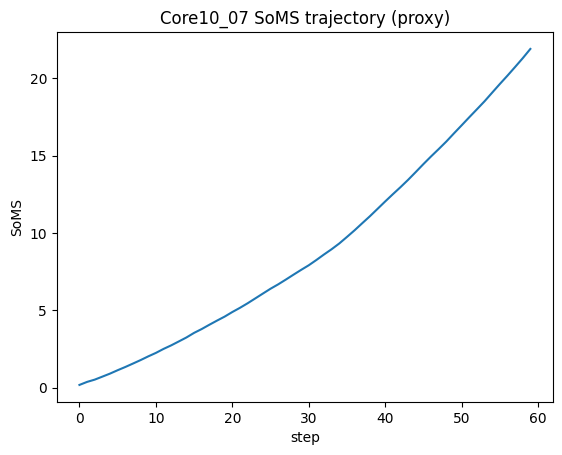

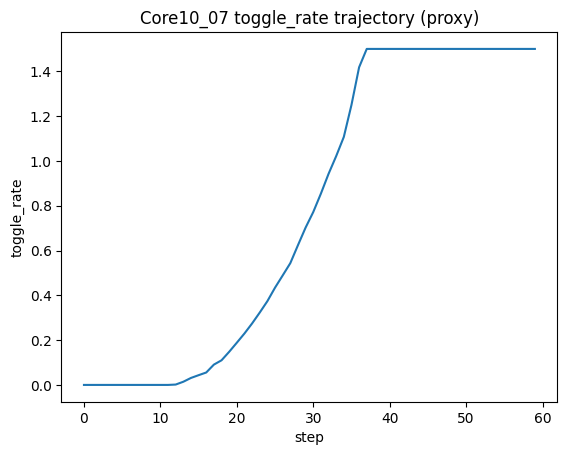

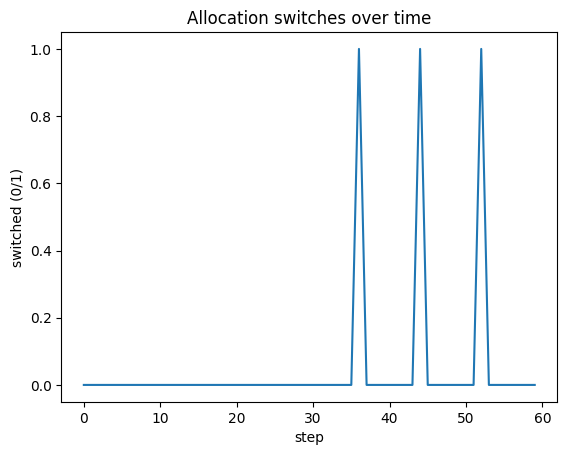

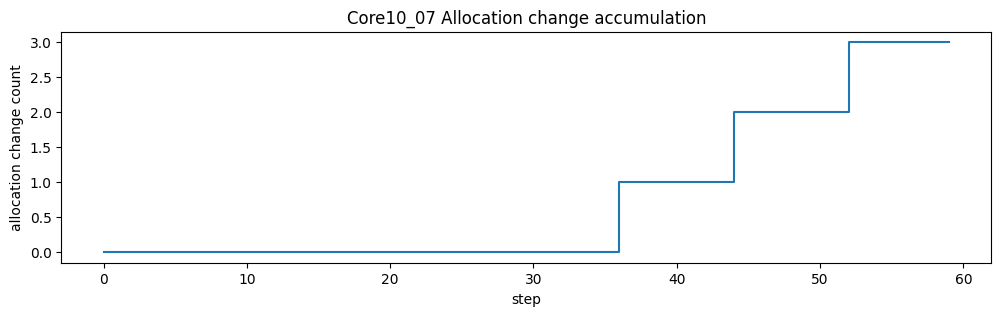

In [11]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(rollout["step"], rollout["SoMS"])
plt.xlabel("step")
plt.ylabel("SoMS")
plt.title("Core10_07 SoMS trajectory (proxy)")
plt.show()

plt.figure()
plt.plot(rollout["step"], rollout["toggle_rate"])
plt.xlabel("step")
plt.ylabel("toggle_rate")
plt.title("Core10_07 toggle_rate trajectory (proxy)")
plt.show()

# selection changes
plt.figure()
plt.plot(rollout["step"], rollout["switched"])
plt.xlabel("step")
plt.ylabel("switched (0/1)")
plt.title("Allocation switches over time")

plt.figure(figsize=(12, 3))
plt.step(
    rollout["step"],
    rollout["allocation_changed"].cumsum(),
    where="post"
)
plt.xlabel("step")
plt.ylabel("allocation change count")
plt.title("Core10_07 Allocation change accumulation")
plt.show()